# Stage 1 - Code Study Allennlp + DataReader, SparseAdjacencyField (See DEV_STAGES.md for update)
- 8/?-8/?
- code study allennlp (across stages)
    - study tools and resources
        - allennlp guide
        - allennlp doc
        - allennlp github (source code)
        - google
    - data
        - fields
        - instances
        - batch
        - dataset
        - vocabulary
    - data operator
        - reader(to_instance)
        - vocab.from_instances
        - token_indexer(index_with => token_id)
        - dataloader(call batch_tensors in fields)
        - embedder(token_id2vec)
        - encoder(model part)
    - trainer
        - trainer
        - tensorboard_writer
        - config file composition and jsonnet
    - general work flow conclusion
        - rawdata =reader=> instance (with fields)
        - instance =Vocab=> vocab (with namespaces)
        - instance =IndexWith=> indexed_instances (TensorDict)
        - instances =dataloader(batch_tensors function)=> batch_tensor (TensorDict)
        - batch_tensor =model=> logits
    - allennlp conclusion
        - OOP + dependency injection
        - a good coding style
        - several robust off-the-shelf models
- implementation of datareader
    - use utils.doc2graph
    - graph2instance
- implementation of SparseAdjacencyField
    - sparse version of origin AdjacencyField
    - modify code (almost all) of allennlp AdjacencyField
    - implementation of PytorchGeoData Batching

# Stage 2 - Train a naive model (BagofWordPooling) with allennlp train
- 8/?-8/?
- (start this note when 2->3)
- mismatched BERT (use defualt mean)
    - use PretrainedTransformerMismatchedIndexer + PretrainedTransformerMismatchedEmbedder
    - note that here use BERT without special token
    - also "[ROOT]" in dependency graph is not special token to BERT is a potential issue
- sparse2dense, dense2sparse in tensorop.py
    - naive implementation works well without tensor
    - fix gradient issue
        - learn about leaf node in computatino graph
        - inplace operation
        - tensor properties
        - torch.sparse.Tensor.to_dense() as tf.scatter_nd
    - 2020/8/21, can actually use pytorch_scatter, pytorch_sparse...
- allennlp train can work with my modules
    
    
# (Now) State 3 - Train A HGNN model (het graph embedding w/o interaction)
- due 8/22
- add Graph2VecEncoder Registrable
- implement HGEN

# Stage 4 - Train A HGMN model (het graph matching network (may be final))
- due 8/31
- add GraphPair2VecEncoder Registrable
- implement HGMN

# Stage 5 - Validation on ANLI/Q-Test/HAN, Experiments
- due 9/15
- parse ANLI/HAN
- Q-Test generator(This may be required earlier)

# Stage 6 - Paper Fixing (due 9/19, EACL due 9/20)

# Now Work, Todo
- reader to add bidirectional relation
    - add add_edge for simplicity
- GraphEMbeddingNet(GraphPair2VecEncoder)
    - todo
- Config is modified
    - remove or transformer embedder
    - can train on token embedding first (quicker and see effect)
    - also a must do exp
- add raw_text_datareader
- tensor_op
    - move sparse cross attention to tensor_op

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import config
import utils
import reader

In [16]:
## util
import os
import logging
from argparse import ArgumentParser
from tqdm import tqdm_notebook as tqdmnb
from tqdm import tqdm as tqdm
import pickle
import json 
import jsonlines as jsonl
from collections import defaultdict
from typing import Iterable, List, Dict, Tuple, Union
from pathlib import Path
## graph
import networkx as nx
import matplotlib.pyplot as plt
## nn
import numpy as np
import torch
from torch_geometric.utils.convert import to_networkx
from torch_geometric.data.data import Data
## Stanza
import stanza
from stanza.models.common.doc import Document
from stanza.pipeline.core import Pipeline
## allennlp model
from allennlp_models.structured_prediction.predictors.srl import SemanticRoleLabelerPredictor
from allennlp_models.structured_prediction.predictors.biaffine_dependency_parser import BiaffineDependencyParserPredictor
from allennlp.predictors.predictor import Predictor #
## allennlp
from allennlp.data import Token, Vocabulary, Instance
from allennlp.data.fields import ListField, TextField, Field
from allennlp.data.token_indexers import (
    SingleIdTokenIndexer,
    TokenCharactersIndexer,
    ELMoTokenCharactersIndexer,
    PretrainedTransformerIndexer,
    PretrainedTransformerMismatchedIndexer,
)
from allennlp.data import DatasetReader, DataLoader, Instance, Vocabulary, PyTorchDataLoader
from allennlp.data.tokenizers import (
    CharacterTokenizer,
    PretrainedTransformerTokenizer,
    SpacyTokenizer,
    WhitespaceTokenizer,
)
from allennlp.modules.seq2vec_encoders import CnnEncoder
from allennlp.modules.text_field_embedders import BasicTextFieldEmbedder
from allennlp.modules.token_embedders import (
    Embedding,
    TokenCharactersEncoder,
    ElmoTokenEmbedder,
    PretrainedTransformerEmbedder,
    PretrainedTransformerMismatchedEmbedder,
)
from allennlp.nn import util as nn_util

In [3]:
%pwd

'/work/2020-IIS-NLU-internship/MNLI/src'

In [4]:
# use relative by concatting pwd
# or the cahce file name will be ..SLASH........
bert_model = "bert-base-uncased"
train_data_path = "/work/2020-IIS-NLU-internship/MNLI/data/anli_v1.0/R1/train.jsonl"
validation_data_path = "/work/2020-IIS-NLU-internship/MNLI/data/anli_v1.0/R1/dev.jsonl"
test_data_path = "/work/2020-IIS-NLU-internship/MNLI/data/anli_v1.0/R1/test.jsonl"
cache_data_dir = "/work/2020-IIS-NLU-internship/MNLI/data/ANLI_instance_cache/R1"

## Stanza NLP

In [5]:
import stanza
stanza.download('en')
nlp = stanza.Pipeline(lang='en', processors='tokenize,mwt,pos,lemma,depparse')

2020-08-22 23:56:21 INFO: Downloading default packages for language: en (English)...
2020-08-22 23:56:23 INFO: File exists: /root/stanza_resources/en/default.zip.
2020-08-22 23:56:29 INFO: Finished downloading models and saved to /root/stanza_resources.
2020-08-22 23:56:29 WARNING: Can not find mwt: default from official model list. Ignoring it.
2020-08-22 23:56:29 INFO: Loading these models for language: en (English):
| Processor | Package |
-----------------------
| tokenize  | ewt     |
| pos       | ewt     |
| lemma     | ewt     |
| depparse  | ewt     |

2020-08-22 23:56:29 INFO: Use device: gpu
2020-08-22 23:56:29 INFO: Loading: tokenize
2020-08-22 23:56:33 INFO: Loading: pos
2020-08-22 23:56:34 INFO: Loading: lemma
2020-08-22 23:56:35 INFO: Loading: depparse
2020-08-22 23:56:36 INFO: Done loading processors!


In [6]:
rdr = reader.NLIGraphReader(input_parsed=False, parser=nlp, cache_directory=cache_data_dir, input_fields=reader.config.anli_fields)
rdr._input_parsed

In [8]:
dev_set = rdr.read(file_path=validation_data_path)
train_set = rdr.read(file_path=train_data_path)
test_set = rdr.read(file_path=test_data_path)

In [6]:
rdr2 = reader.NLIGraphReader(input_fields=reader.config.default_fields)

In [7]:
dev2 = rdr2.read(file_path="../data/anli_v1.0_preprocessed/R2/dev.jsonl")

In [8]:
" ".join([str(token) for token in dev2[0].fields["tokens_p"].tokens])

'[ROOT] Clear Hearts Grey Flowers is the second full - length and final album by Jack Off Jill . [ROOT] Produced by Chris Vrenna of Nine Inch Nails / Tweaker , it was released in July 2000 on the now - defunct label Risk Records . [ROOT] After " Clear Hearts , Grey Flowers " the band formally split up and moved on to establish other projects .'

In [9]:
del utils
import utils

In [10]:
data = utils.text2graph("Clear Hearts Grey Flowers is the second full", nlp)
type(data)

torch_geometric.data.data.Data

[0, 1, 2, 3, 4, 5, 6, 7, 8]
[(0, 2), (1, 2), (2, 1), (2, 0), (2, 8), (3, 4), (4, 3), (4, 8), (5, 8), (6, 8), (7, 8), (8, 4), (8, 5), (8, 6), (8, 7), (8, 2)]


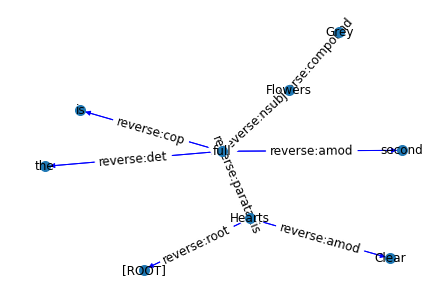

In [11]:
utils.draw(data=data, node_size=100, font_size=12, save_img_file=None)

# Batch Testing Model

In [54]:
vocab = Vocabulary.from_instances(dev2, min_count={"edge_labels":500})
# min_count={"edge_labels":150} => 58
# min_count={"edge_labels":500} => 46
# min_count={"edge_labels":1000} => 42
# 1200 => 36

In [40]:
print(Vocabulary.from_instances.__doc__)


        Constructs a vocabulary given a collection of `Instances` and some parameters.
        We count all of the vocabulary items in the instances, then pass those counts
        and the other parameters, to :func:`__init__`.  See that method for a description
        of what the other parameters do.

        The `instances` parameter does not get an entry in a typical AllenNLP configuration file,
        but the other parameters do (if you want non-default parameters).
        


In [41]:
dev2.index_with(vocab)

In [42]:
loader2 = PyTorchDataLoader(dev2, batch_size=2)

In [43]:
batch = next(iter(loader2))

In [55]:
vocab.print_statistics()



----Vocabulary Statistics----


Top 10 most frequent tokens in namespace 'edge_labels':
	Token: punct		Frequency: 11144
	Token: reverse:punct		Frequency: 11144
	Token: case		Frequency: 8467
	Token: reverse:case		Frequency: 8467
	Token: compound		Frequency: 7251
	Token: reverse:compound		Frequency: 7251
	Token: det		Frequency: 6507
	Token: reverse:det		Frequency: 6507
	Token: obl		Frequency: 4153
	Token: reverse:obl		Frequency: 4153

Top 10 longest tokens in namespace 'edge_labels':
	Token: reverse:compound:prt		length: 20	Frequency: 40
	Token: reverse:flat:foreign		length: 20	Frequency: 11
	Token: reverse:nsubj:pass		length: 18	Frequency: 1008
	Token: reverse:nmod:npmod		length: 18	Frequency: 20
	Token: reverse:cc:preconj		length: 18	Frequency: 16
	Token: reverse:det:predet		length: 18	Frequency: 6
	Token: reverse:nmod:poss		length: 17	Frequency: 923
	Token: reverse:acl:relcl		length: 17	Frequency: 456
	Token: reverse:parataxis		length: 17	Frequency: 96
	Token: reverse:obl:npmod		len

In [56]:
vocab

Vocabulary with namespaces:  edge_labels, Size: 46 || labels, Size: 3 || Non Padded Namespaces: {'*tags', '*labels'}

In [31]:
nlp("I sleeped") # note that should take lemmatized as node attr if use work embedding

[
  [
    {
      "id": "1",
      "text": "I",
      "lemma": "I",
      "upos": "PRON",
      "xpos": "PRP",
      "feats": "Case=Nom|Number=Sing|Person=1|PronType=Prs",
      "head": 2,
      "deprel": "nsubj",
      "misc": "start_char=0|end_char=1"
    },
    {
      "id": "2",
      "text": "sleeped",
      "lemma": "sleep",
      "upos": "VERB",
      "xpos": "VBD",
      "feats": "Mood=Ind|Tense=Past|VerbForm=Fin",
      "head": 0,
      "deprel": "root",
      "misc": "start_char=2|end_char=9"
    }
  ]
]